# Particle size distribution from BSE images in the SEM

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

2019-03-20
___

In this notebook we go through the steps of characterising shape properties of 2nd phase particles in a material from backscatter electron (BSE) images from a scanning electron microscope (SEM).

Procedure:  
1. Import and inspect data.  
2. Detect particles based upon image intensity using region-based segmentation (following scikit-image's [Image Segmentation](http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html) tutorial):     
    i. Create an **elevation map** with particle edges highlighted.  
    ii. Find **markers** of each particle and the background.  
    iii. Perform a **watershed transformation** by flooding the elevation map starting from the markers.
3. Segment labeled image into particles and analyse particle properties:  
    i. Segment particles from binary image.  
    ii. Get particle properties (using scikit-image's [`skimage.measure.regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html#regionprops)).  
    iii. Remove wrongly segmented particles and confirm successful segmentation.  
4. Plot results:  
    i. Particle size.  
    ii. Particle density.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sco
import scipy.special as scs
from skimage.filters import sobel
from skimage.color import rgb2gray, label2rgb
from skimage.exposure import rescale_intensity
from skimage import morphology
from skimage import measure
from scipy import ndimage as ndi

newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
             'lines.markersize': 10, 'lines.linewidth': 2,
             'font.size': 15, 'figure.dpi': 200}
plt.rcParams.update(newparams)

/home/hakon/miniconda3/envs/py37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## 1. Import and inspect data

The example BSE image was acquired by Eirik Bugten Hamnes at NTNU, Norway.

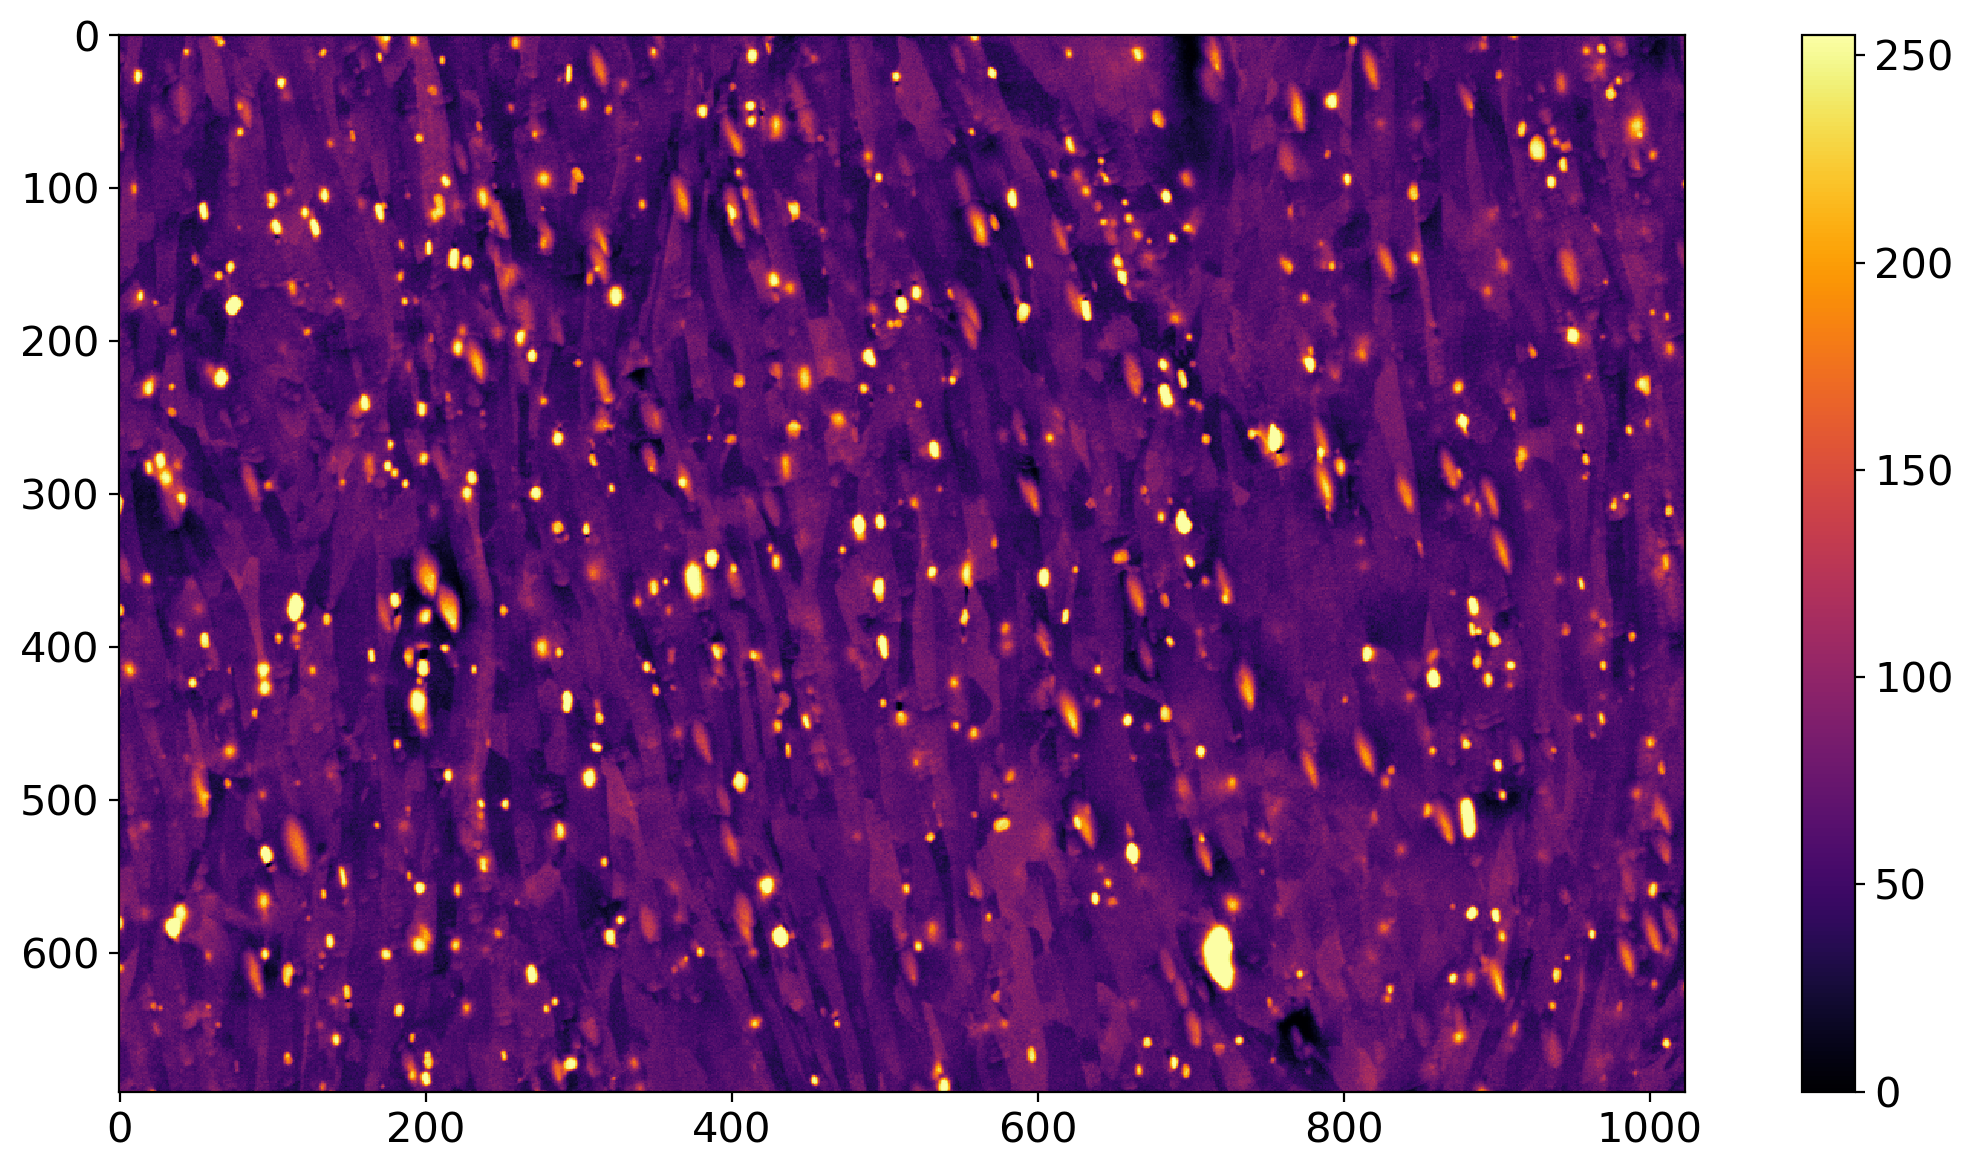

In [2]:
# Read data from file
data = 'bse.tif'
datadir, fname = os.path.split(data)
fname, ext = os.path.splitext(fname)
bse = plt.imread(data)

# Crop away lower part with image data and NTNU logo
bse = bse[:691]

# Convert image to grayscale and 8 bit [0, 255] (don't need that high depth)
bse = rgb2gray(bse)
bse = rescale_intensity(bse, out_range=np.uint8)

# Inspect image
plt.imshow(bse, cmap=plt.cm.inferno)
plt.colorbar();

## 2. Detect particles based upon image intensity using region-based segmentation

### i. Create an elevation map with particle edges highlighted

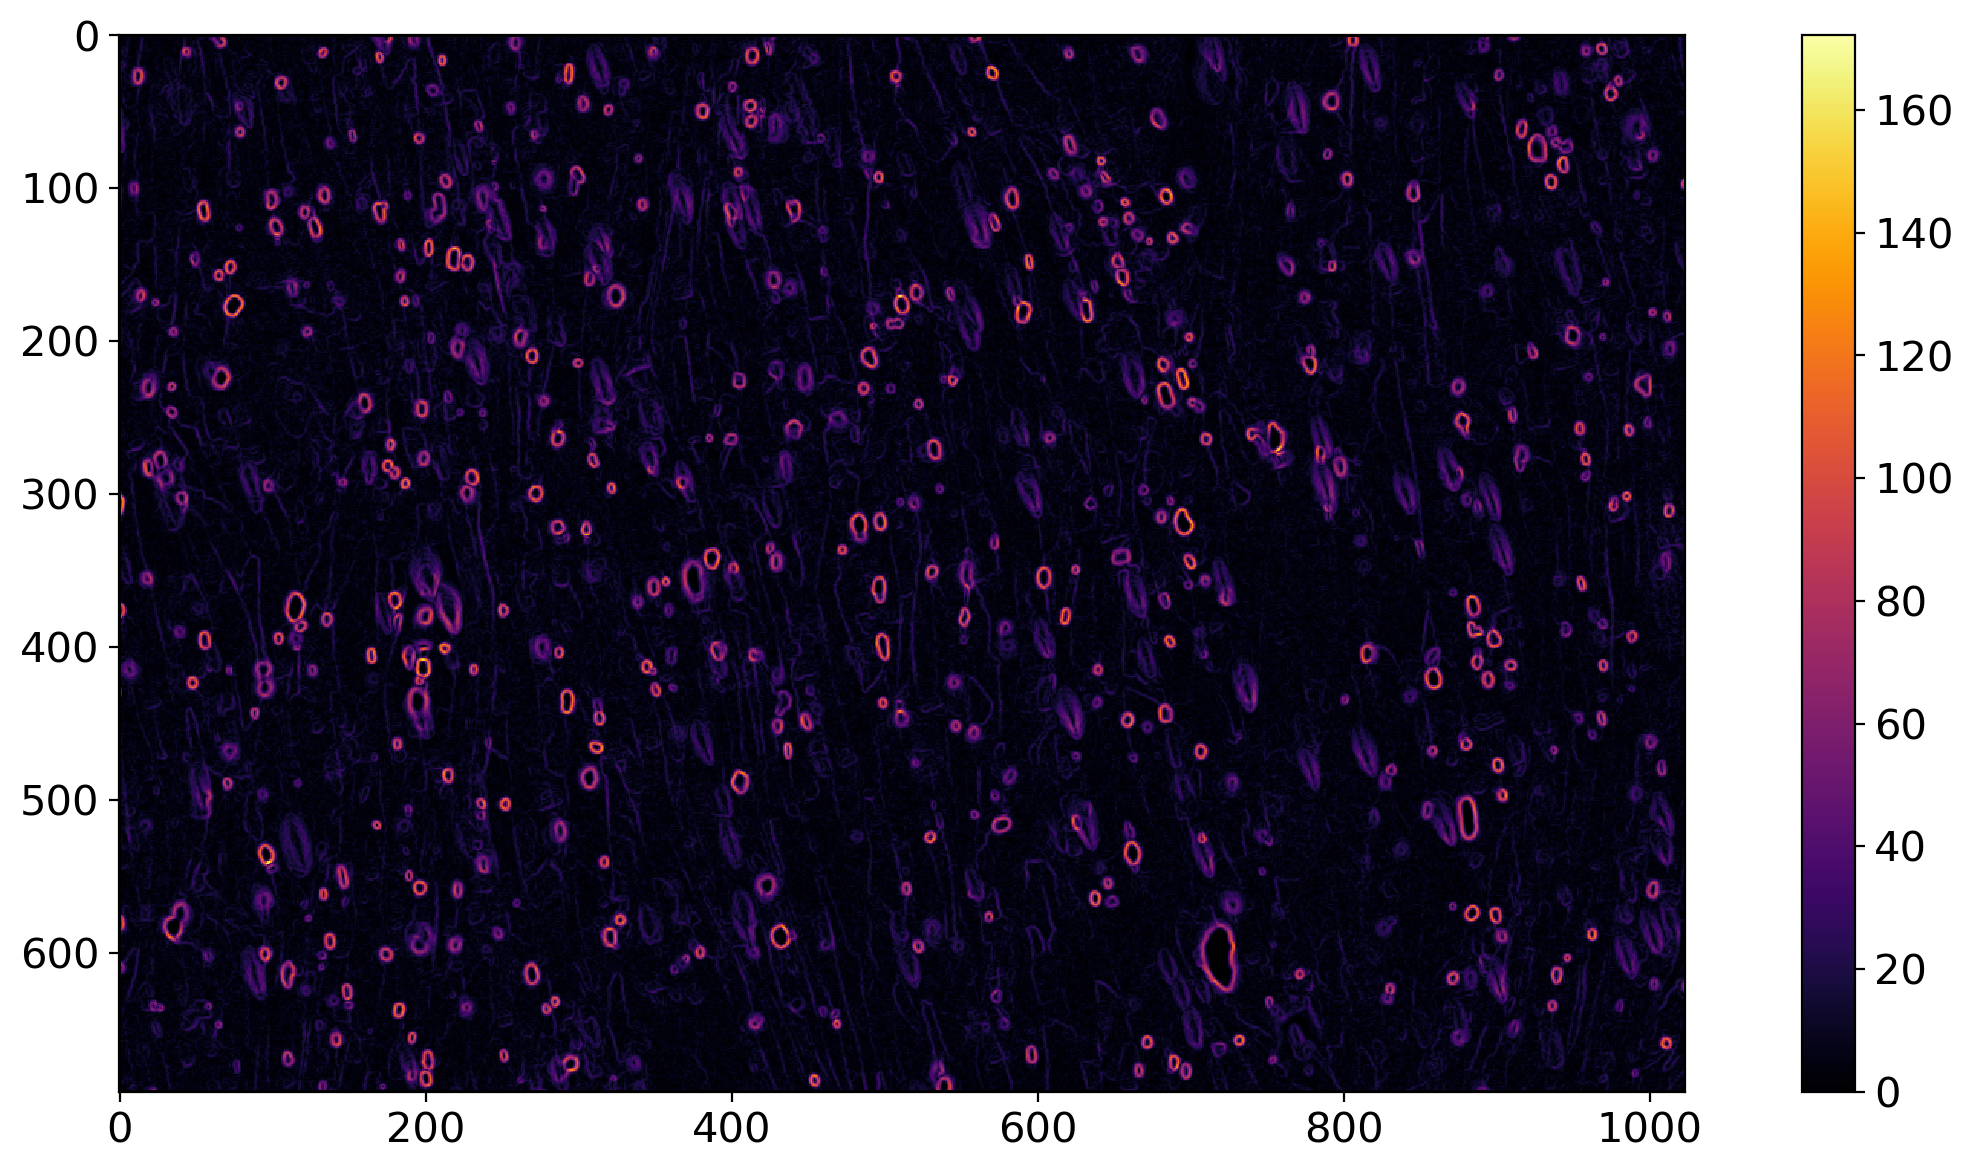

In [3]:
elevation_map = sobel(bse)

plt.imshow(elevation_map, cmap=plt.cm.inferno)
plt.colorbar();

### ii. Find markers of each particle and the background

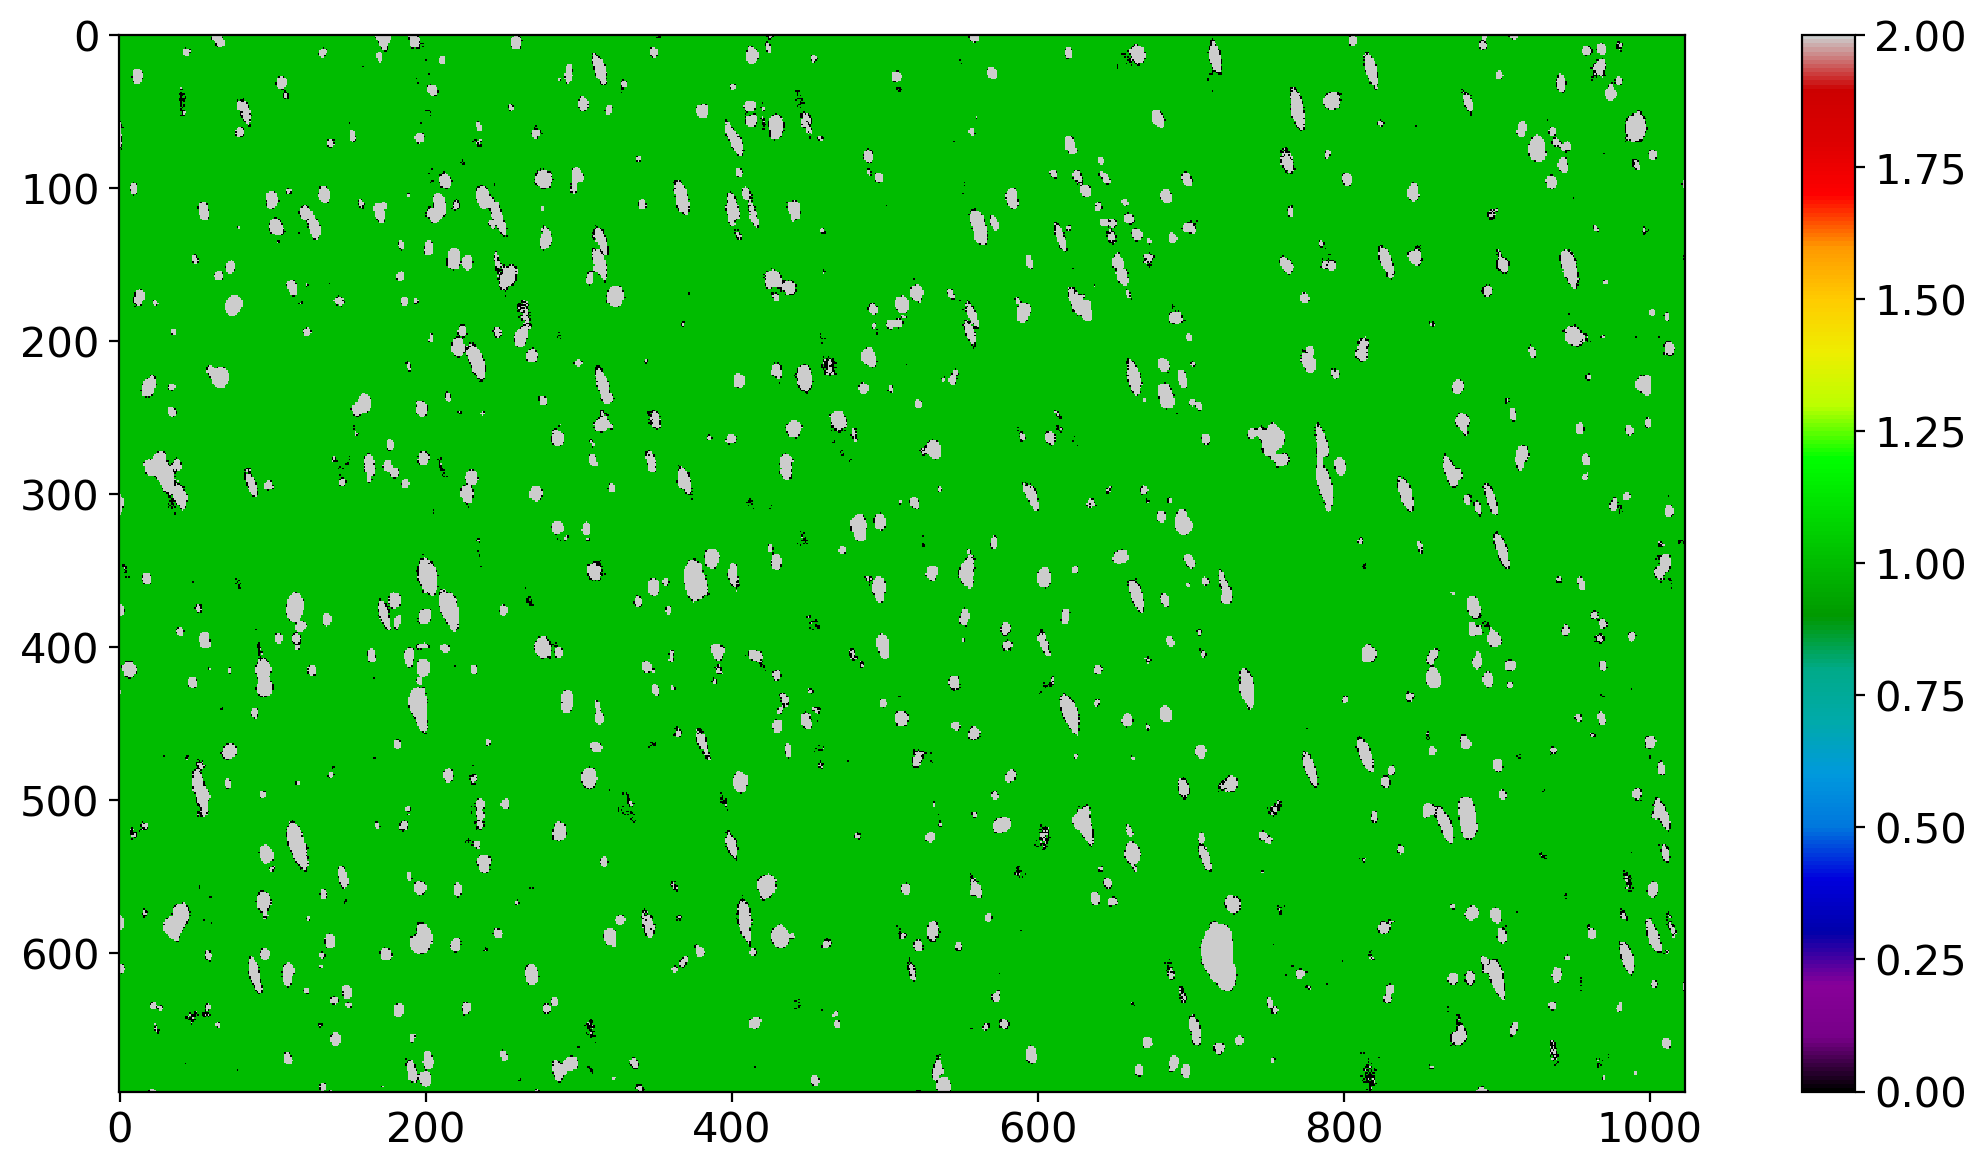

In [4]:
markers = np.zeros_like(bse)
markers[bse < 110] = 1
markers[bse > 120] = 2

plt.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.colorbar();

### iii. Perform a watershed transformation by flooding the elevation map starting from the markers

/home/hakon/miniconda3/envs/py37/lib/python3.7/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


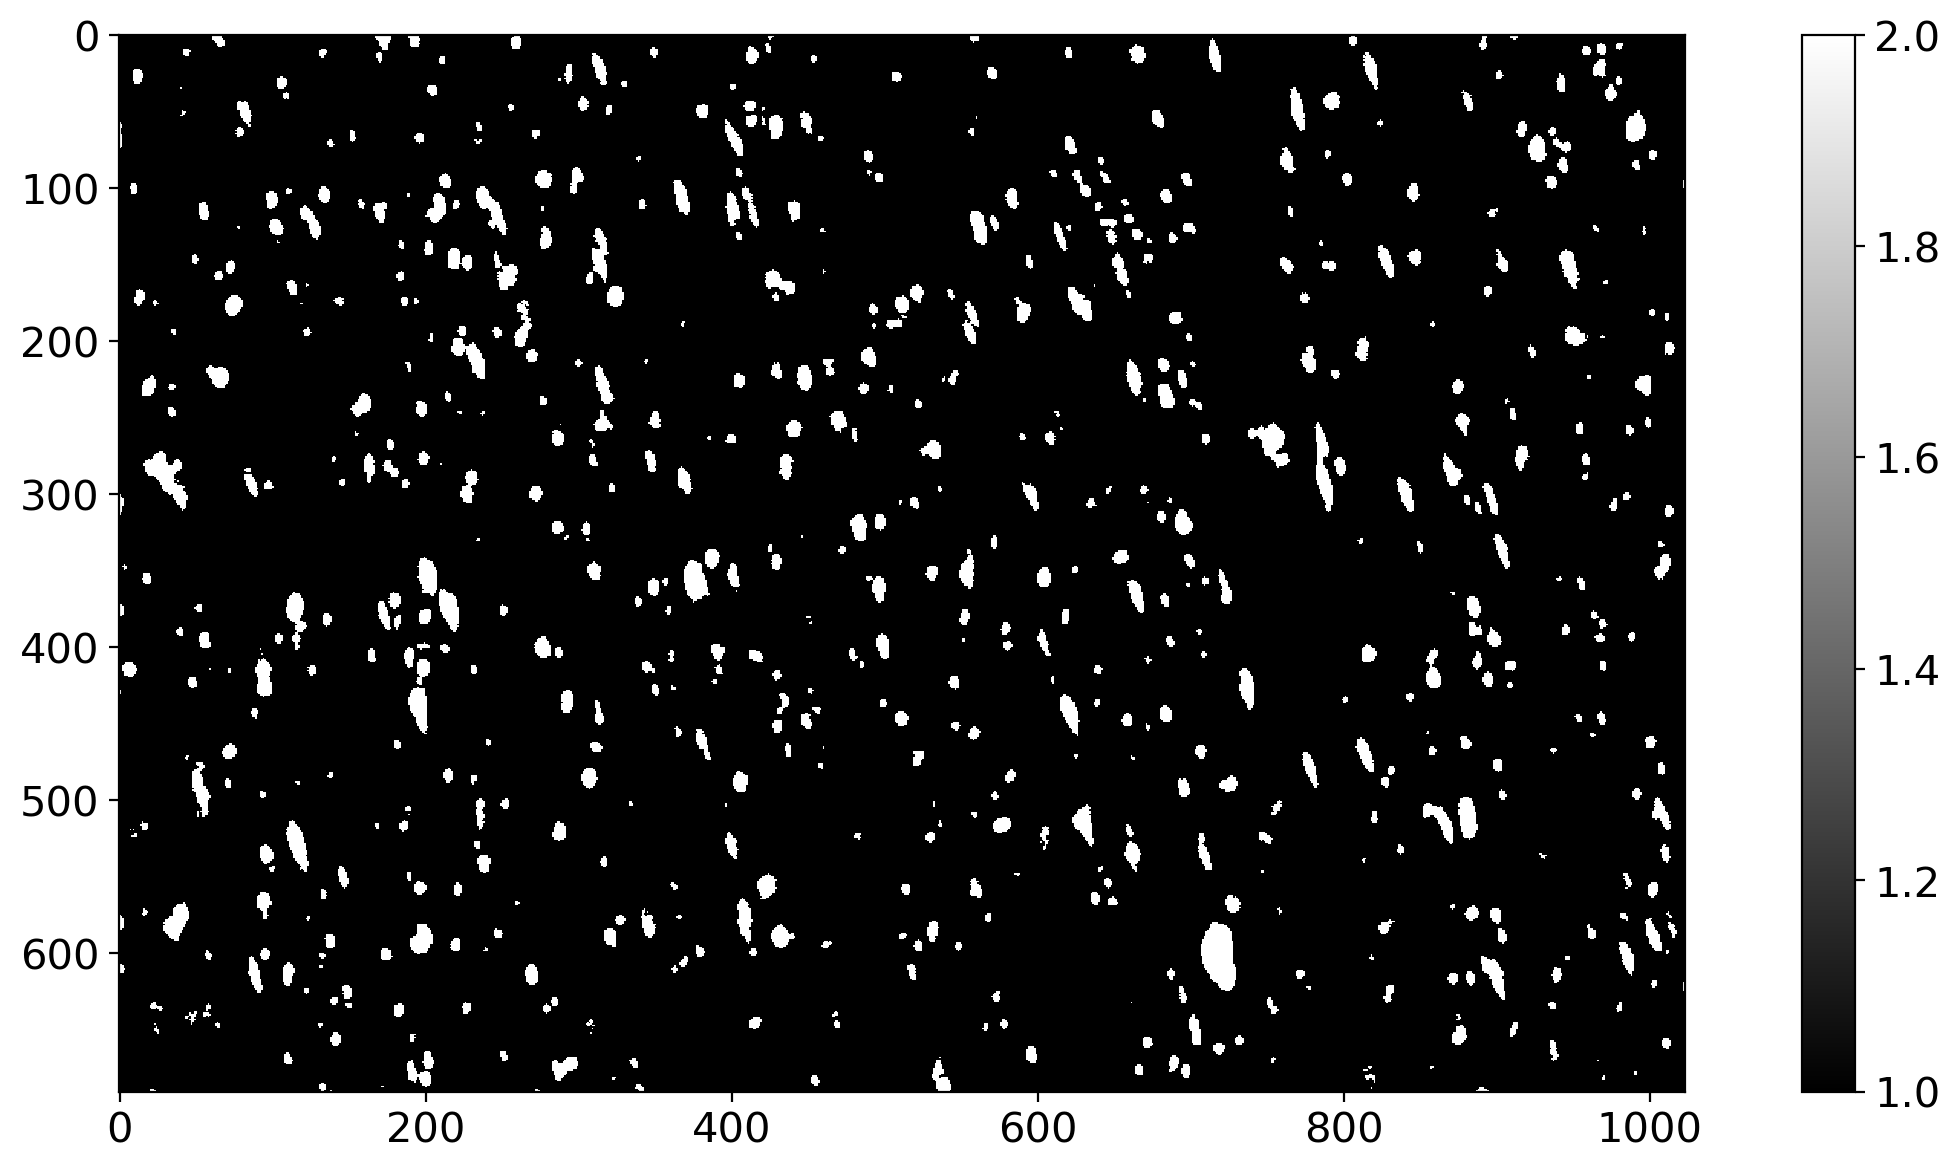

In [5]:
segmentation = morphology.watershed(elevation_map, markers)

plt.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar();

## 3. Segment labeled image into particles and analyse particle properties

### i. Segment particles from binary image

695 particles were segmented.


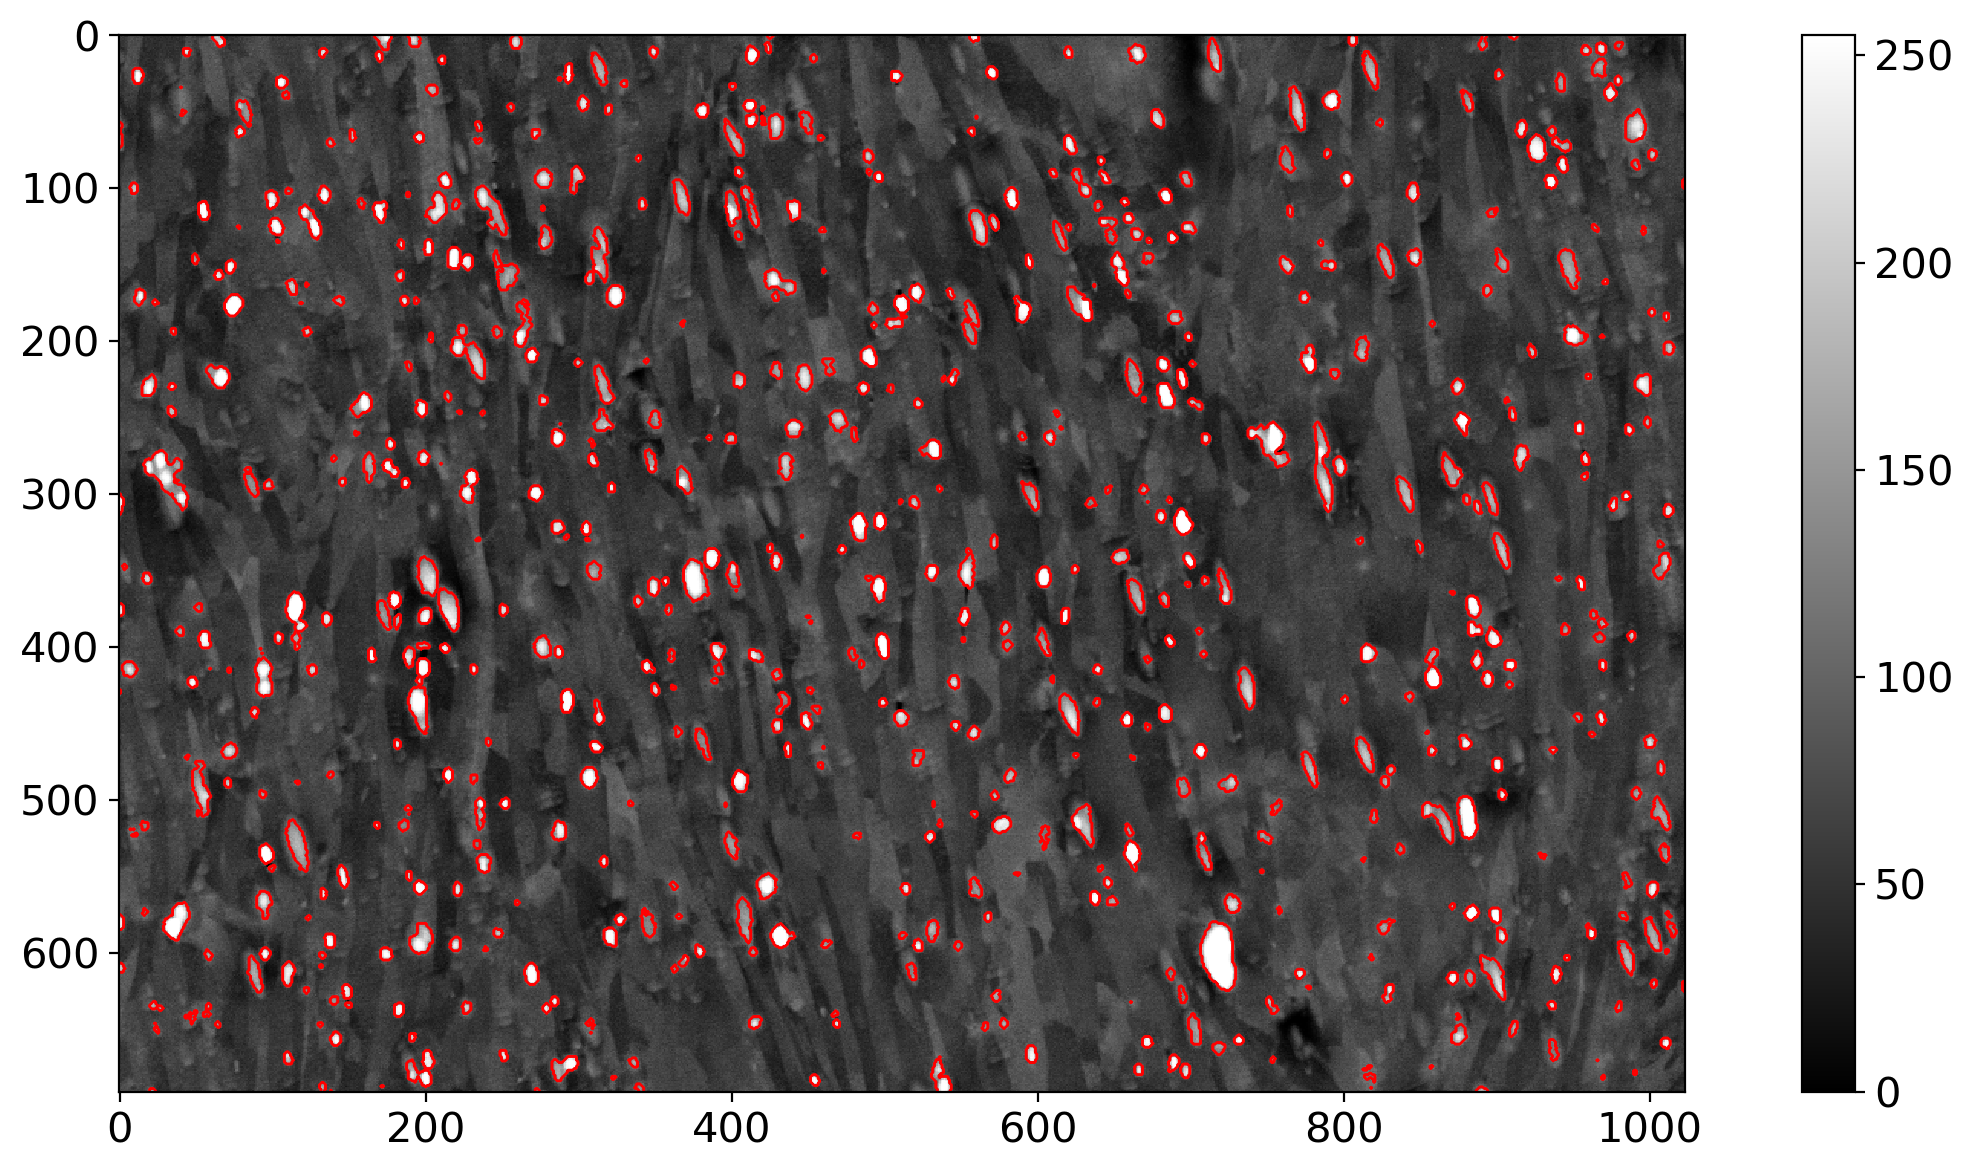

In [6]:
segmentation2 = ndi.binary_fill_holes(segmentation - 1)
labeled_particles, n = ndi.label(segmentation2)

print("{} particles were segmented.".format(n))

# Inspect segmentation
plt.imshow(bse, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar()
plt.contour(segmentation, linewidths=0.5, colors='r');

### ii. Get particle properties

It is important to get the image scale correct.

In [7]:
# Get properties of labeled regions
props = measure.regionprops(labeled_particles, intensity_image=bse)

# Initiate data frame with columns for properties of interest
props_columns = ['pixels', 'equivalent_diameter', 'eccentricity', 'perimeter',
                 'ellipse_major_axis', 'ellipse_minor_axis', 'centroid']
particles = pd.DataFrame(columns=props_columns)

# Image scale
scale = (1/45)*1e3  # [nm/px]

for region in props:
    particles.loc[len(particles)] = [region.area,
                                     region.equivalent_diameter * scale,
                                     region.eccentricity,
                                     region.perimeter * scale,
                                     region.major_axis_length * scale,
                                     region.minor_axis_length * scale,
                                     region.centroid]

# Remove too small particles
particles = particles[particles['pixels'] > 10]
particles = particles[particles['eccentricity'] >= 0]

n_new = len(particles)
print("{}/{} particles were removed after filtering on pixels and eccentricity.".format(n - n_new, n))

# Set derived properties
particles['area'] = particles.pixels.values * scale**2
particles['circularity'] = 4*np.pi*particles.area.values/particles.perimeter.values**2

particles.sort_values(by='area', inplace=True)
particles.reset_index(inplace=True, drop=True)

/home/hakon/miniconda3/envs/py37/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/hakon/miniconda3/envs/py37/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


137/695 particles were removed after filtering on pixels and eccentricity.


### iii. Remove wrongly segmented particles and confirm successful segmentation

23/558 particles were removed after filtering on circularity.


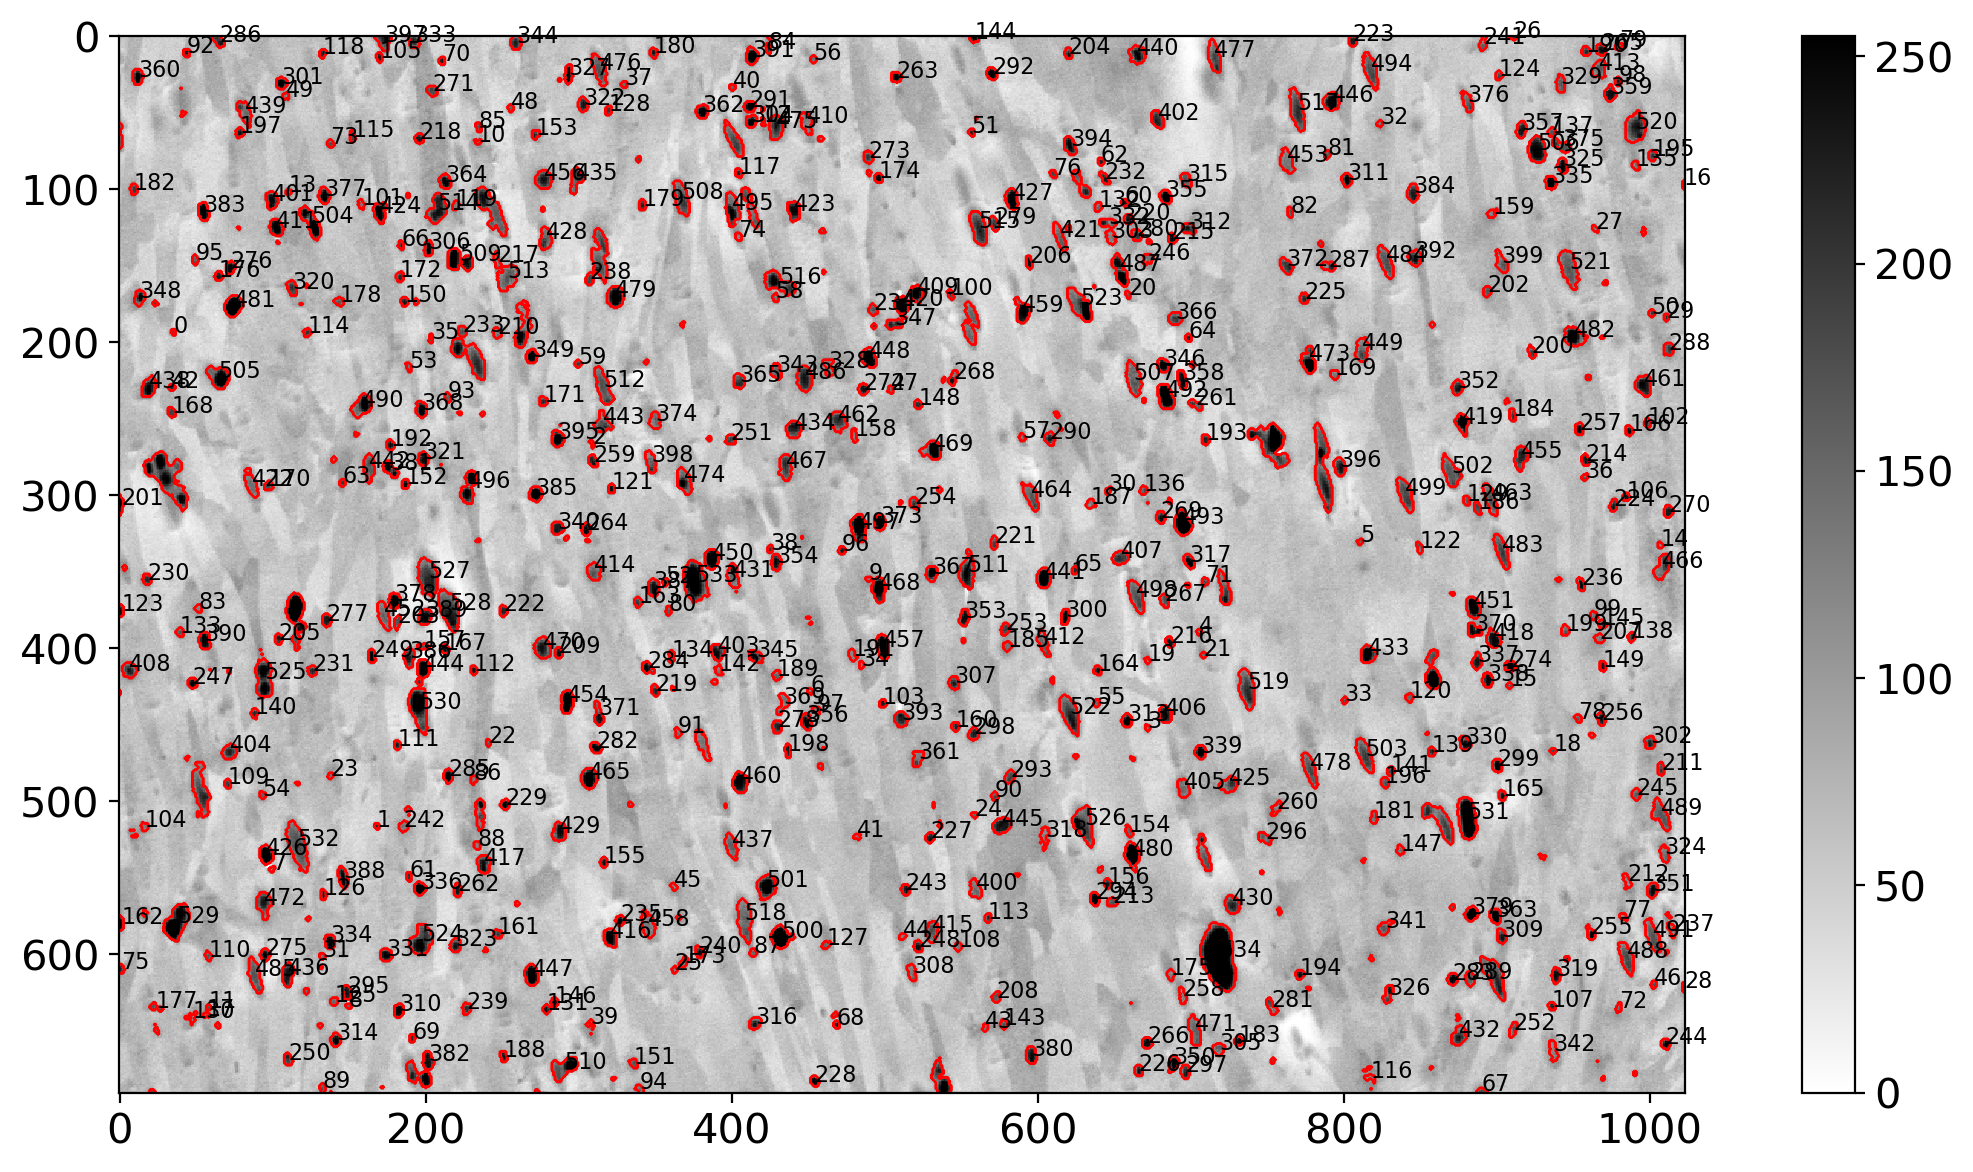

In [8]:
particles = particles[particles['circularity'] > 0.5]

n_new2 = len(particles)
print("{}/{} particles were removed after filtering on circularity.".format(n_new - n_new2, n_new))

# Plot inverse intensity map
plt.imshow(bse, cmap=plt.cm.gray_r, interpolation='nearest')
plt.colorbar()
plt.contour(segmentation, linewidths=0.5, colors='r');

for i, (x, y) in enumerate(particles.centroid.values):
    plt.text(y, x, s='%i' % i, fontdict={'size': 8})

## 4. Plot results

### i. Particle size

Ideally, a distribution, typically gamma or lognormal, describing the particle size distribution should be fitted.

In [9]:
def gamma(x, a, b):
    return b**a/scs.gamma(a)*x**(a - 1)*np.exp(-b*x)


def lognormal(x, s, m):
    return 1/(s*x*np.sqrt(2*np.pi))*np.exp(-0.5*((np.log(x) - m)/s)**2)

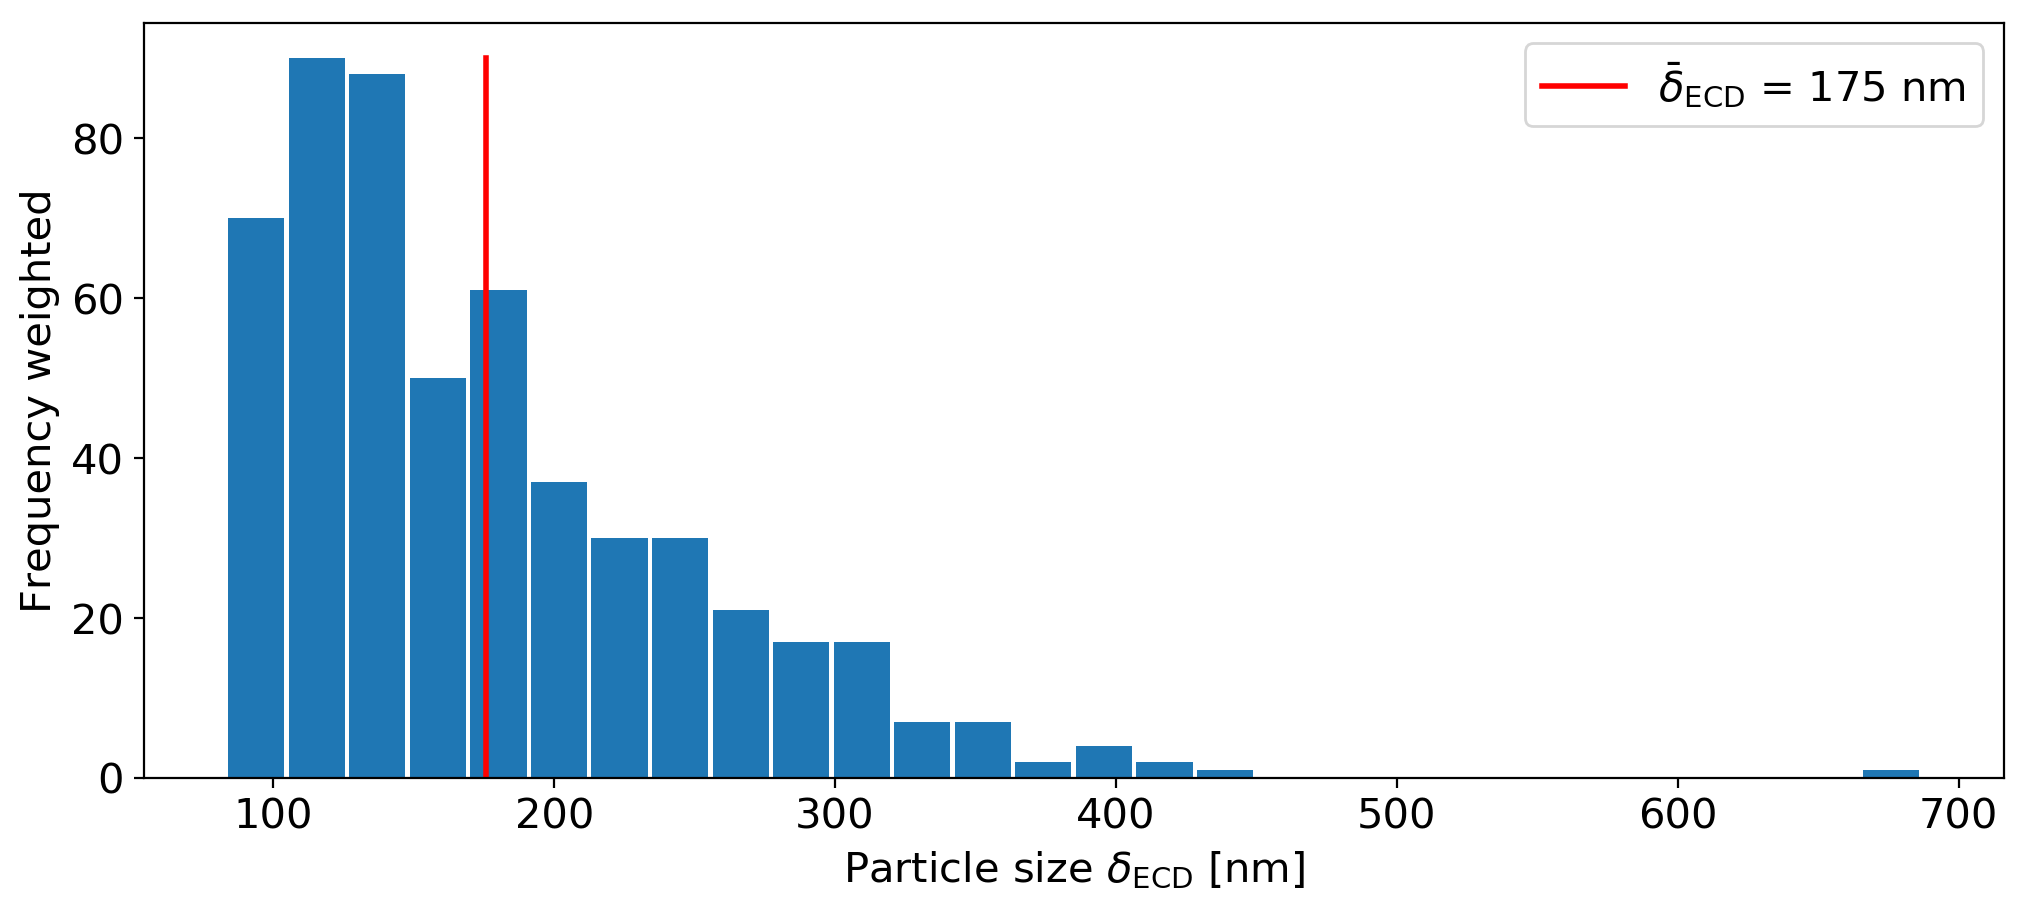

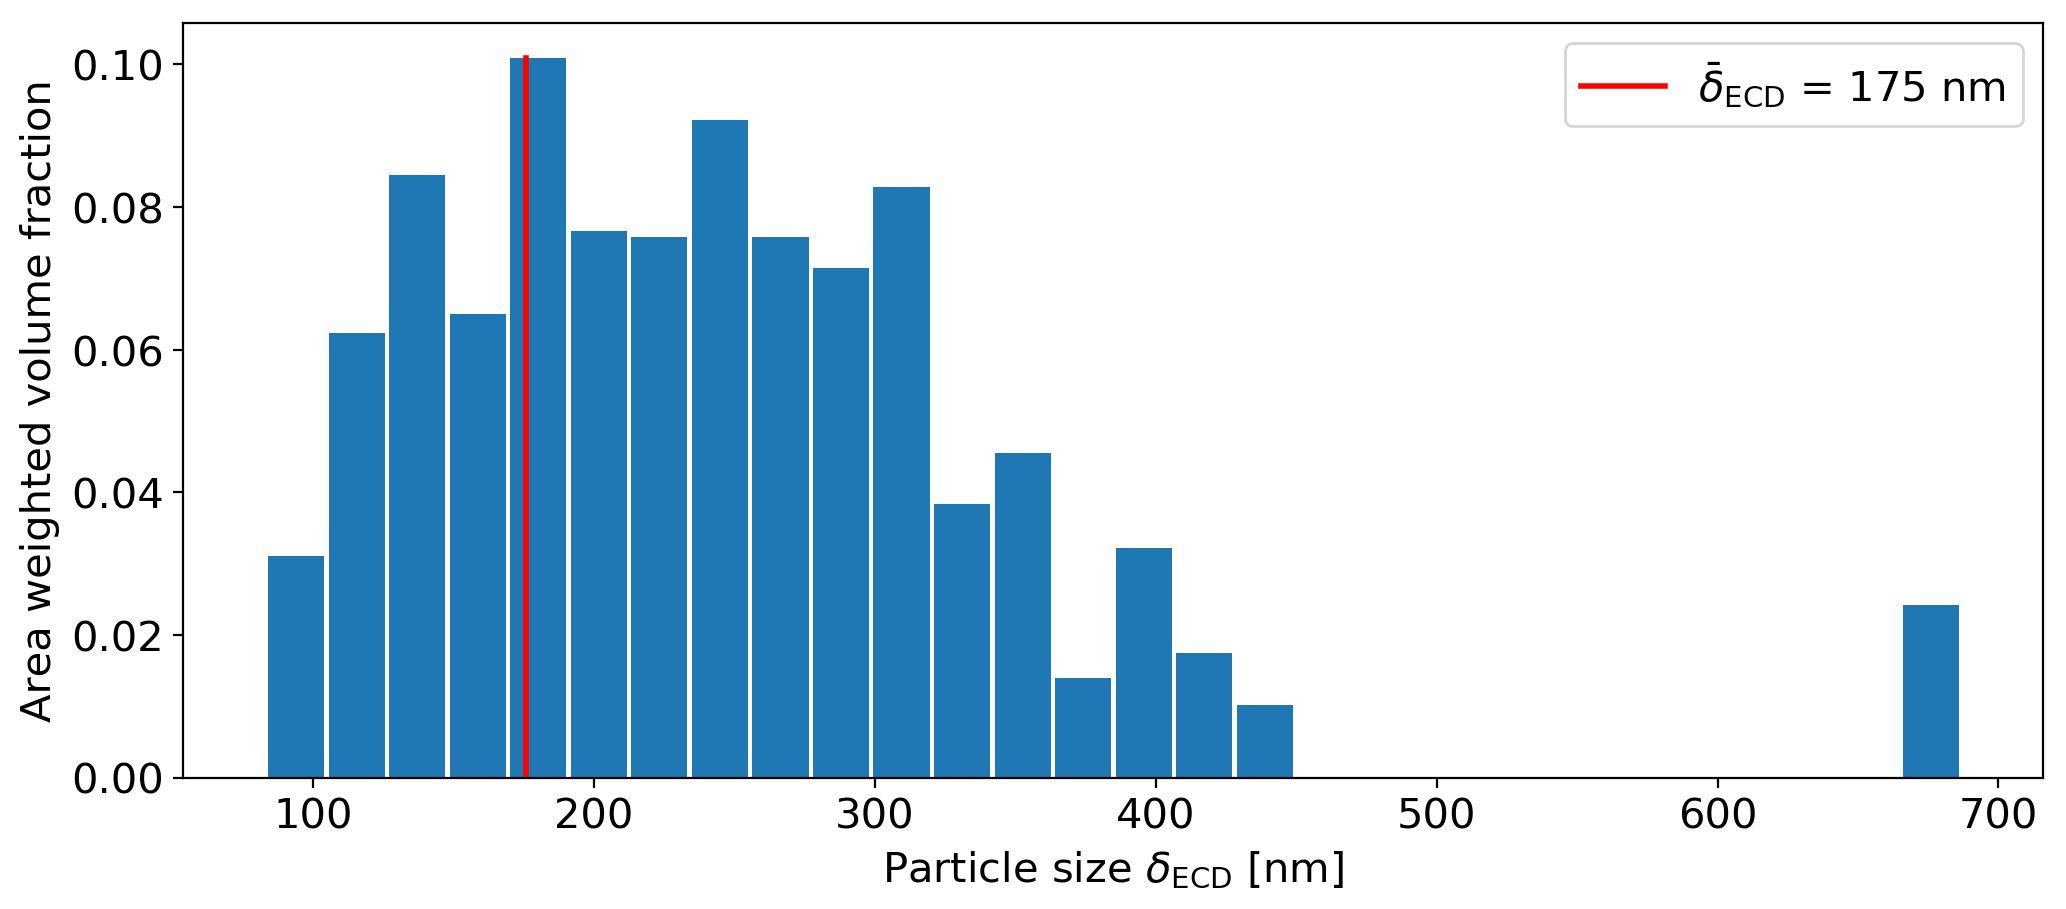

In [10]:
# Plot results
bin_width = 25
x_max = np.max(particles.equivalent_diameter)
num_bins = int(x_max/bin_width + 1)

# Frequency weighted particle
hist, bins = np.histogram(particles.equivalent_diameter, bins=num_bins)
centre = (bins[:-1] + bins[1:])/2

# Fit curve
#x_curves = np.linspace(particles.equivalent_diameter.min(),
#                       particles.equivalent_diameter.max(), 100)
#popt, pcov = sco.curve_fit(gamma, xdata=centre, ydata=hist, bounds=(0, 10))
#hist_fit = gamma(x_curves, *popt)

# Normalised area weighted particle size
hist_area, bins_area = np.histogram(particles.equivalent_diameter,
                                    bins=num_bins, weights=particles.area,
                                    density=True)
hist_norm_area = hist_area/np.sum(hist_area)
centre_area = (bins_area[:-1] + bins_area[1:])/2

# Mean diameter and standard deviation
ecd_mean = particles.equivalent_diameter.mean()
ecd_std = particles.equivalent_diameter.std()

# Plotting
bar_width = 0.8*bin_width
bar_align = 'center'
label_mean = r'$\bar{\delta}_{\mathrm{ECD}}$ = %i nm' % ecd_mean

# Frequency weighted
fig, ax = plt.subplots(figsize=(12, 5))
#label_fit = r'$\Gamma$ fit: $\alpha$ = %.2f, $\beta$ = %.2f' % (popt[0], popt[1])
ax.bar(centre, hist, width=bar_width, align=bar_align)
ax.plot([ecd_mean, ecd_mean], [0, hist.max()], 'r', label=label_mean)
#ax.plot(x_curves, hist_fit, '-r', linewidth=3, label=label_fit)
ax.set_xlabel(r'Particle size $\delta_{\mathrm{ECD}}$ [nm]')
ax.set_ylabel('Frequency weighted')
ax.legend()
#plt.savefig(os.path.join(datadir, 'particle_size_freq.png'), dpi=300,
#            bbox_inches='tight')

# Normalised area weighted
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(centre_area, hist_norm_area, width=bar_width, align=bar_align)
ax.plot([ecd_mean, ecd_mean], [0, hist_norm_area.max()], 'r', label=label_mean)
ax.set_xlabel(r'Particle size $\delta_{\mathrm{ECD}}$ [nm]')
ax.set_ylabel('Area weighted volume fraction')
ax.legend();
#plt.savefig(os.path.join(datadir, 'particle_size_area.png'), dpi=300,
#           bbox_inches='tight')

### ii. Particle density

In [11]:
# Image area
image_area = bse.size * scale**2 * 1e-12  # [mm^2]

# Density
density_frequency = len(particles) / image_area  # [#/mm^2]
density_area = 100*particles.pixels.sum() / bse.size  # [%]

print("Particle density = {:.3E} #/mm^2\nParticle area = {:.2f}%".format(density_frequency,
                                                                       density_area))

Particle density = 1.531E+06 #/mm^2
Particle area = 4.38%


___
### Finally, write the data to file

In [12]:
# particles.to_csv(os.path.join(datadir, 'particles.csv'))